In [1]:
# Imports
#

import numpy             as np
import matplotlib        as mpl
import matplotlib.pyplot as plt
import math

In [2]:
# Set config constants

n_train, n_val, n_test = 3000, 1000, 3000
n_tot = sum([n_train, n_val, n_test])

radius_boundary_1, radius_boundary_2 = 0.6, 1.2

sqrt_2 = np.sqrt(2)

mpl.rcParams['font.size'] = 16

In [3]:
# Ground-truth function for classifying points
#

def classify (p) :
    if type(p) != np.ndarray :
        if p < radius_boundary_1 : return np.array([1, 0, 0])
        if p < radius_boundary_2 : return np.array([0, 1, 0])
        return np.array([0, 0, 1])
    if p.shape == 1 :
        p = np.array([p])
    if len(p.shape) == 2 :
        radii = np.linalg.norm(p, axis=1)
    else :
        raise ValueError(f"cannot get radii for list of points with shape {p.shape} ((n_points, n_dim) expected)")
    return np.array([classify(r) for r in radii])

In [4]:
# Function for plotting classified points
#

def plot_points (points, labels, **kwargs) :
    pnts_A = np.array([p for p, l in zip(points, labels) if l[0] > max(l[1], l[2])])
    pnts_B = np.array([p for p, l in zip(points, labels) if l[1] > max(l[0], l[2])])
    pnts_C = np.array([p for p, l in zip(points, labels) if l[2] > max(l[0], l[1])])
    plt.axis((-1.*sqrt_2, sqrt_2, -1.*sqrt_2, sqrt_2))
    if pnts_A.shape[0] > 0 :
        plt.scatter(pnts_A[:,0], pnts_A[:,1], marker="o", c="g", s=4, alpha=0.4)
    if pnts_B.shape[0] > 0 :
        plt.scatter(pnts_B[:,0], pnts_B[:,1], marker="o", c="r", s=4, alpha=0.4)
    if pnts_C.shape[0] > 0 :
        plt.scatter(pnts_C[:,0], pnts_C[:,1], marker="o", c="b", s=4, alpha=0.4)
    theta = np.linspace(0, 2*math.pi, 100)
    plt.plot(radius_boundary_1*np.cos(theta), radius_boundary_1*np.sin(theta), "--", c="black")
    plt.plot(radius_boundary_2*np.cos(theta), radius_boundary_2*np.sin(theta), "--", c="black")
    if "title" in kwargs : plt.title(kwargs["title"], pad=15)
    plt.xlabel("x", labelpad=20)
    plt.xticks(fontsize="small")
    plt.ylabel("y", rotation="horizontal", labelpad=30)
    plt.yticks(fontsize="small")
    plt.show()

In [5]:
# Function for assigning weights to datapoints based on the class frequency
#

def get_label_weights (labels) :
    n_labels = np.sum(labels, axis=0)
    n_points = np.sum(labels)
    label_weights = np.reciprocal(n_labels/n_points)
    return np.matmul(labels, label_weights)

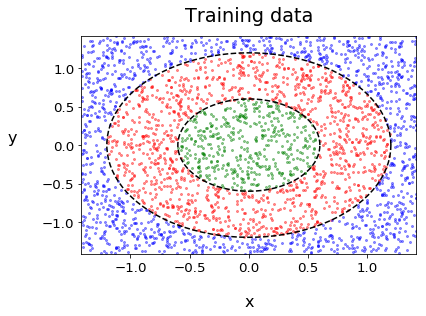

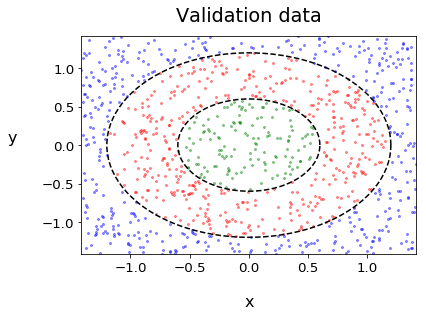

In [6]:
# Generate labelled data in (x, y)-plane over the domain x, y \in [-sqrt(2), sqrt(2)]
#

all_inputs = np.random.uniform(-1.*sqrt_2, sqrt_2, size=(n_tot, 2))
all_labels = classify(all_inputs)

X_train, X_val, X_test = all_inputs[:n_train], all_inputs[n_train:n_train+n_val], all_inputs[n_val:n_val+n_test]
Y_train, Y_val, Y_test = all_labels[:n_train], all_labels[n_train:n_train+n_val], all_labels[n_val:n_val+n_test]
W_train, W_val, W_test = get_label_weights(Y_train), get_label_weights(Y_val), get_label_weights(Y_test)

plot_points(X_train, Y_train, title="Training data")
plot_points(X_val  , Y_val  , title="Validation data")

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

standard_classifier = Sequential(name="Standard Keras classifier")
standard_classifier.add(Dense(64, activation="relu", input_shape=(2,)))
standard_classifier.add(Dropout(0.3))
standard_classifier.add(Dense(64, activation="relu"))
standard_classifier.add(Dropout(0.3))
standard_classifier.add(Dense(64, activation="relu"))
standard_classifier.add(Dense(3 , activation="relu"))
standard_classifier.add(Activation("softmax"))
standard_classifier.compile(optimizer="adam",
                            loss="categorical_crossentropy",
                            metrics=["accuracy"])
#standard_classifier.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
from keras.callbacks import EarlyStopping

standard_classifier.fit(X_train,
                        Y_train,
                        sample_weight=W_train,
                        validation_data=(X_val, Y_val, W_val),
                        epochs=10000,
                        callbacks=[EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=100)])

Instructions for updating:
Use tf.cast instead.
Train on 3000 samples, validate on 1000 samples
Epoch 1/10000
3000/3000 [==============================] - 0s 163us/step - loss: 2.8925 - accuracy: 0.5493 - val_loss: 2.2756 - val_accuracy: 0.8310
Epoch 2/10000
3000/3000 [==============================] - 0s 95us/step - loss: 1.7752 - accuracy: 0.7477 - val_loss: 1.0375 - val_accuracy: 0.8710
Epoch 3/10000
3000/3000 [==============================] - 0s 85us/step - loss: 1.1709 - accuracy: 0.7983 - val_loss: 0.6772 - val_accuracy: 0.9270
Epoch 4/10000
3000/3000 [==============================] - 0s 66us/step - loss: 0.9601 - accuracy: 0.8387 - val_loss: 0.5444 - val_accuracy: 0.9280
Epoch 5/10000
3000/3000 [==============================] - 0s 54us/step - loss: 0.8390 - accuracy: 0.8533 - val_loss: 0.5183 - val_accuracy: 0.9370
Epoch 6/10000
3000/3000 [==============================] - 0s 55us/step - loss: 0.7805 - accuracy: 0.8653 - val_loss: 0.4262 - val_accuracy: 0.9580
Epoch 7/10000
3

Epoch 54/10000
3000/3000 [==============================] - 0s 54us/step - loss: 0.3913 - accuracy: 0.9357 - val_loss: 0.5296 - val_accuracy: 0.8810
Epoch 55/10000
3000/3000 [==============================] - 0s 55us/step - loss: 0.4033 - accuracy: 0.9310 - val_loss: 0.4276 - val_accuracy: 0.9020
Epoch 56/10000
3000/3000 [==============================] - 0s 54us/step - loss: 0.3924 - accuracy: 0.9353 - val_loss: 0.4212 - val_accuracy: 0.9050
Epoch 57/10000
3000/3000 [==============================] - 0s 55us/step - loss: 0.3675 - accuracy: 0.9340 - val_loss: 0.4282 - val_accuracy: 0.9020
Epoch 58/10000
3000/3000 [==============================] - 0s 55us/step - loss: 0.3960 - accuracy: 0.9343 - val_loss: 0.3591 - val_accuracy: 0.9200
Epoch 59/10000
3000/3000 [==============================] - 0s 57us/step - loss: 0.4109 - accuracy: 0.9277 - val_loss: 0.4549 - val_accuracy: 0.8940
Epoch 60/10000
3000/3000 [==============================] - 0s 55us/step - loss: 0.3844 - accuracy: 0.9360

Epoch 109/10000
3000/3000 [==============================] - 0s 53us/step - loss: 0.3119 - accuracy: 0.9483 - val_loss: 0.7148 - val_accuracy: 0.8680
Epoch 110/10000
3000/3000 [==============================] - 0s 52us/step - loss: 0.2934 - accuracy: 0.9520 - val_loss: 0.4534 - val_accuracy: 0.9030
Epoch 111/10000
3000/3000 [==============================] - 0s 55us/step - loss: 0.2922 - accuracy: 0.9470 - val_loss: 0.5056 - val_accuracy: 0.8930
Epoch 112/10000
3000/3000 [==============================] - 0s 54us/step - loss: 0.2725 - accuracy: 0.9550 - val_loss: 0.3022 - val_accuracy: 0.9290
Epoch 113/10000
3000/3000 [==============================] - 0s 54us/step - loss: 0.2960 - accuracy: 0.9543 - val_loss: 0.4838 - val_accuracy: 0.8980


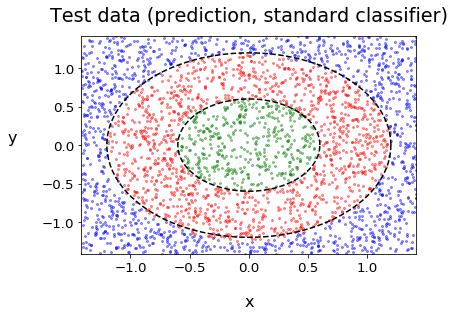

In [9]:
plot_points(X_test, standard_classifier.predict(X_test), title="Test data (prediction, standard classifier)")

In [10]:
from keras        import backend as K
from keras.layers import Layer, Add

class Custom_Dense (Layer) :
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Custom_Dense, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1]+1, self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Custom_Dense, self).build(input_shape)  # Be sure to call this at the end
    def call(self, x):
        return K.bias_add(K.dot(x, self.kernel[1:]), self.kernel[0])
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

class Custom_Relu (Layer) :
    def call(self, x):
        return 0.5 * (x + K.abs(x))
    def compute_output_shape(self, input_shape):
        return input_shape

class Custom_Softmax (Layer) :
    def __init__(self, beta=1., **kwargs):
        self.beta = beta
        super(Custom_Softmax, self).__init__(**kwargs)
    def call(self, x):
        A = K.exp(self.beta*x)
        return A / K.max(A)
    def compute_output_shape(self, input_shape):
        return input_shape

In [12]:
from keras.models import Model
from keras.layers import Input

model_input = Input(shape=(2,), name="input")
custom_layer_1 = Custom_Dense(64)
custom_layer_2 = Custom_Relu()
custom_layer_3 = Custom_Dense(64)
custom_layer_4 = Custom_Relu()
custom_layer_5 = Custom_Dense(64)
custom_layer_6 = Custom_Relu()
custom_layer_7 = Custom_Dense(3)
custom_layer_8 = Custom_Softmax()
model = custom_layer_8(
    custom_layer_7(
        custom_layer_6(
            custom_layer_5(
                custom_layer_4(
                    custom_layer_3(
                        custom_layer_2(
                            custom_layer_1(model_input))))))))
custom_classifier = Model(inputs=model_input, outputs=model)
custom_classifier.compile(optimizer="adam",
                          loss="categorical_crossentropy",
                          metrics=["accuracy"])

In [13]:
custom_classifier  .fit(X_train,
                        Y_train,
                        sample_weight=W_train,
                        validation_data=(X_val, Y_val, W_val),
                        epochs=10000,
                        callbacks=[EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=100)])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 3000 samples, validate on 1000 samples
Epoch 1/10000
3000/3000 [==============================] - 0s 133us/step - loss: 3.1208 - accuracy: 0.4403 - val_loss: 2.2788 - val_accuracy: 0.5740
Epoch 2/10000
3000/3000 [==============================] - 0s 61us/step - loss: 1.1552 - accuracy: 0.8327 - val_loss: 0.6107 - val_accuracy: 0.9440
Epoch 3/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.4592 - accuracy: 0.9470 - val_loss: 0.3485 - val_accuracy: 0.9540
Epoch 4/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.3275 - accuracy: 0.9633 - val_loss: 0.2681 - val_accuracy: 0.9690
Epoch 5/10000
3000/3000 [==============================] - 0s 52us/step - loss: 0.2792 - accuracy: 0.9597 - val_loss: 0.2574 - val_accuracy: 0.9670
Epoch 6/10000
3000/3000 [==============================] - 0s 85us/step - loss: 0.2503 - accuracy: 0.9677 - val_loss: 0.2023 - val_ac

3000/3000 [==============================] - 0s 50us/step - loss: 0.1320 - accuracy: 0.9813 - val_loss: 0.2062 - val_accuracy: 0.9610
Epoch 54/10000
3000/3000 [==============================] - 0s 50us/step - loss: 0.1182 - accuracy: 0.9807 - val_loss: 0.1542 - val_accuracy: 0.9750
Epoch 55/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.0917 - accuracy: 0.9873 - val_loss: 0.0879 - val_accuracy: 0.9810
Epoch 56/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.1133 - accuracy: 0.9807 - val_loss: 0.4257 - val_accuracy: 0.9390
Epoch 57/10000
3000/3000 [==============================] - 0s 50us/step - loss: 0.1382 - accuracy: 0.9793 - val_loss: 0.0989 - val_accuracy: 0.9810
Epoch 58/10000
3000/3000 [==============================] - 0s 49us/step - loss: 0.0882 - accuracy: 0.9870 - val_loss: 0.1163 - val_accuracy: 0.9840
Epoch 59/10000
3000/3000 [==============================] - 0s 48us/step - loss: 0.1197 - accuracy: 0.9820 - val_loss: 0.

3000/3000 [==============================] - 0s 52us/step - loss: 0.0908 - accuracy: 0.9840 - val_loss: 0.1441 - val_accuracy: 0.9700
Epoch 109/10000
3000/3000 [==============================] - 0s 52us/step - loss: 0.0776 - accuracy: 0.9867 - val_loss: 0.1190 - val_accuracy: 0.9800
Epoch 110/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.1035 - accuracy: 0.9810 - val_loss: 0.1861 - val_accuracy: 0.9680
Epoch 111/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.1150 - accuracy: 0.9810 - val_loss: 0.2717 - val_accuracy: 0.9650
Epoch 112/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.0991 - accuracy: 0.9857 - val_loss: 0.0803 - val_accuracy: 0.9890
Epoch 113/10000
3000/3000 [==============================] - 0s 51us/step - loss: 0.0702 - accuracy: 0.9907 - val_loss: 0.1048 - val_accuracy: 0.9810
Epoch 114/10000
3000/3000 [==============================] - 0s 52us/step - loss: 0.0825 - accuracy: 0.9867 - val_lo

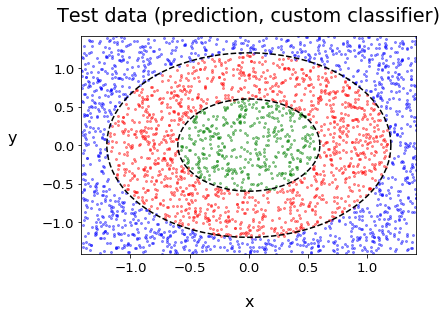

In [14]:
plot_points(X_test, custom_classifier.predict(X_test), title="Test data (prediction, custom classifier)")